# Prediction of future number of rides

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import datetime

from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
import pylab as py
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

#### Variables

In [3]:
DAYS_A_WEEK = 7
WEEKS_LAG_SIZE = 2
BASIC_TRAINING_SET_NUM_WEEKS = 12
SLIDING_WINDOW_WEEK_STEP_SIZE = 1

### Load Rides Data

In [4]:
df_rides = pd.read_csv('rides.csv')
df_rides.head()

,RIDE_ID,created_on,created_on_hour,started_on,completed_on,distance_travelled
0,0,2016-06-04 00:10:19,2016-06-04 00:00:00,2016-06-04 00:18:49,2016-06-04 00:27:32,8459.0
1,1,2016-06-04 01:47:39,2016-06-04 01:00:00,2016-06-04 01:50:12,2016-06-04 01:51:49,443.0
2,2,2016-06-04 03:13:07,2016-06-04 03:00:00,2016-06-04 03:16:02,2016-06-04 03:17:57,568.0
3,3,2016-06-04 09:52:35,2016-06-04 09:00:00,2016-06-04 10:05:13,2016-06-04 10:13:38,4051.0
4,4,2016-06-04 10:23:25,2016-06-04 10:00:00,2016-06-04 10:24:25,2016-06-04 10:26:07,790.0


### Data Exploration

#### Describe the data

#### Aggregate the number of rides per hour

In [5]:
df_hourly_rides = df_rides.groupby('created_on_hour')['RIDE_ID'].count().reset_index().\
rename(columns={'RIDE_ID': 'rides'})

df_hourly_rides['created_on_hour'] = pd.to_datetime(df_hourly_rides['created_on_hour'])
df_hourly_rides.head()

,created_on_hour,rides
0,2016-06-04 00:00:00,1
1,2016-06-04 01:00:00,1
2,2016-06-04 03:00:00,1
3,2016-06-04 09:00:00,1
4,2016-06-04 10:00:00,1


#### Number of rides per day

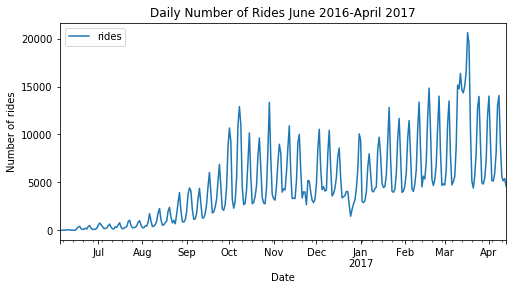

In [6]:
# get the dates
df_hourly_rides['date'] = df_hourly_rides['created_on_hour'].dt.date

# count the rides per day
df_daily_rides = df_hourly_rides.groupby('date')['rides'].sum().reset_index()
df_daily_rides['date'] = pd.to_datetime(df_daily_rides['date'])

p = df_daily_rides.plot(x='date', y='rides', figsize=(8,4), title='Daily Number of Rides June 2016-April 2017')
plab1 = p.set_ylabel('Number of rides')
plab2 = p.set_xlabel('Date')


#### Ride distance distribution

In [7]:
# remove 2 rides with missing travelling distance information:
df_rides = df_rides[~(df_rides.distance_travelled.isna())]

# remove 11 rides with distance travel of 0
df_rides = df_rides[(df_rides.distance_travelled != 0)].reset_index()


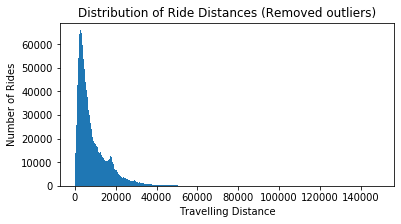

In [8]:
# remove outliers:
df_rides_rmv_ol = df_rides.loc[(np.abs(stats.zscore(df_rides['distance_travelled'])) < 3), :].copy()

plt.figure(figsize=(6, 3))
plt.hist(df_rides_rmv_ol['distance_travelled'], bins=400)
plt.xlabel('Travelling Distance')
plt.ylabel('Number of Rides')
plt.title('Distribution of Ride Distances (Removed outliers)')
plt.show()


#### Normality check

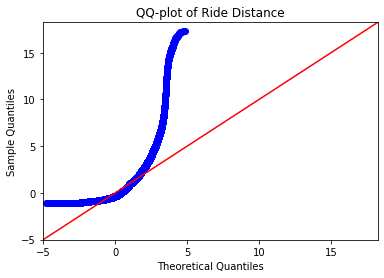

Skewness Index is: |2.57| > 1, indicating that the data is highly skewed and therefore not normal.


In [9]:
# qqplot
sm.qqplot(df_rides_rmv_ol['distance_travelled'], line ='45', fit=True)
plt.title('QQ-plot of Ride Distance')
py.show()

# since the data seems skewed, I will asses the normality by Skewness Index:
print('Skewness Index is: |' + str(round(stats.skew(df_rides_rmv_ol['distance_travelled']), 2)) +
      '| > 1, indicating that the data is highly skewed and therefore not normal.')


#### log-transformation

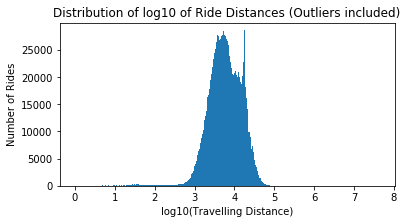

In [10]:
# take log of travelling distance
df_rides['log_distance_travelled'] = np.log10(df_rides.distance_travelled) #+ 1)

plt.figure(figsize=(6, 3))
plt.hist(df_rides['log_distance_travelled'], bins=400)
plt.xlabel('log10(Travelling Distance)')
plt.ylabel('Number of Rides')
plt.title('Distribution of log10 of Ride Distances (Outliers included)')
plt.show()


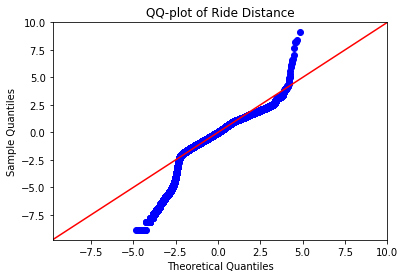

Skewness Index is: 1 >= |-1.0| > 0.5, indicating that the data is moderately skewed and therefore not normal.


In [11]:
# qqplot
sm.qqplot(df_rides['log_distance_travelled'], line ='45', fit=True)
plt.title('QQ-plot of Ride Distance')
py.show()

# since the data seems skewed, I will asses the normality by Skewness Index:
print('Skewness Index is: 1 >= |' + str(round(stats.skew(df_rides['log_distance_travelled']), 2)) +
      '| > 0.5, indicating that the data is moderately skewed and therefore not normal.')

#### log-transformation & outlier removal

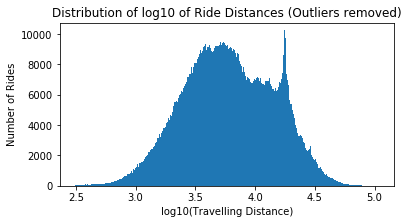

In [12]:
# take log of travelling distance
df_rides['log_distance_travelled'] = np.log10(df_rides.distance_travelled) #+ 1)
# outlier removal:
df_rides_rmv_log_ol = df_rides.loc[(np.abs(stats.zscore(df_rides['log_distance_travelled'])) < 3), :].copy()

plt.figure(figsize=(6, 3))
plt.hist(df_rides_rmv_log_ol['log_distance_travelled'], bins=400)
plt.xlabel('log10(Travelling Distance)')
plt.ylabel('Number of Rides')
plt.title('Distribution of log10 of Ride Distances (Outliers removed)')
plt.show()


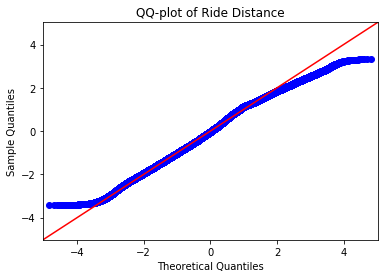

Skewness Index is: |-0.06| ~= 0, indicating that the log-transformed outlier-cleaned ride distance data is 
approximately normal.


In [13]:
# qqplot
sm.qqplot(df_rides_rmv_log_ol['log_distance_travelled'], line ='45', fit=True)
plt.title('QQ-plot of Ride Distance')
py.show()

# since the data seems skewed, I will asses the normality by Skewness Index:
print('Skewness Index is: |' + str(round(stats.skew(df_rides_rmv_log_ol['log_distance_travelled']), 2)) +
      '| ~= 0, indicating that the log-transformed outlier-cleaned ride distance data is \napproximately normal.')


### Load Time Data

In [14]:
df_times = pd.read_csv('times.csv')
df_times['datetime'] = pd.to_datetime(df_times['datetime'])
df_times.head()

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 02:00:00,5,6,4,2016,22,156,False,None,2
3,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
4,2016-06-04 04:00:00,5,6,4,2016,22,156,False,None,4


#### Add times data to rides data

In [15]:
df_hourly_rides_merged = df_hourly_rides.merge(df_times, left_on='created_on_hour', right_on='datetime')

#### Set index to time of ride

In [16]:
hourly_rides = df_hourly_rides_merged.set_index('created_on_hour')
hourly_rides.head(2)

,rides,date,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
created_on_hour,,,,,,,,,,,,
2016-06-04 00:00:00,1,2016-06-04,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
2016-06-04 01:00:00,1,2016-06-04,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1


#### Explore rides at different times of the day

In [17]:
def explore_data(name_of_agg_col, df, add_to_title=''):
    """Creates plots of proportion of rides as a function of columns of the data"""
    df_general_hours_rides = df.groupby(name_of_agg_col)['rides'].sum().reset_index()
    total_number_of_rides = df_general_hours_rides.rides.sum()
    
    plt.figure(figsize=(8, 4))
    p3 = plt.scatter(df_general_hours_rides.loc[:, name_of_agg_col],
                     df_general_hours_rides.rides / total_number_of_rides)
    p3 = plt.plot(df_general_hours_rides.loc[:, name_of_agg_col], 
                  df_general_hours_rides.rides / total_number_of_rides)
    plt.xlabel(name_of_agg_col)
    plt.ylabel('Proportion of Rides')
    plt.title('Proportion of Rides Over ' + name_of_agg_col + ' ' + add_to_title)
    plt.show()

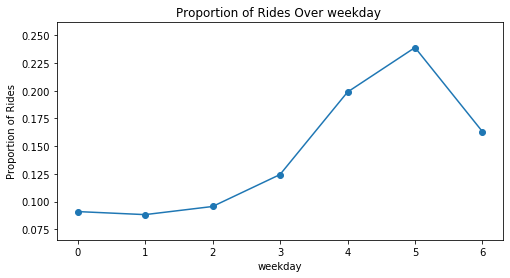

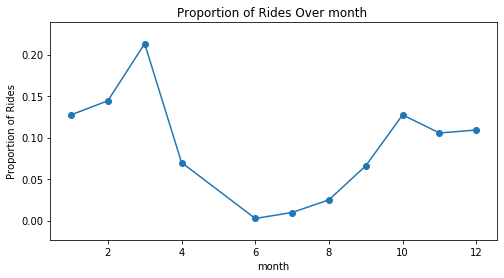

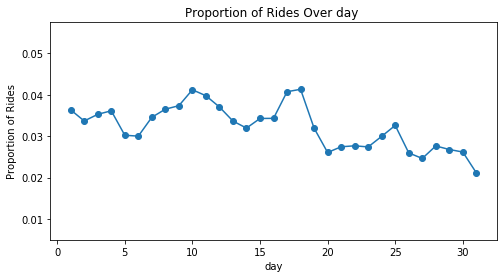

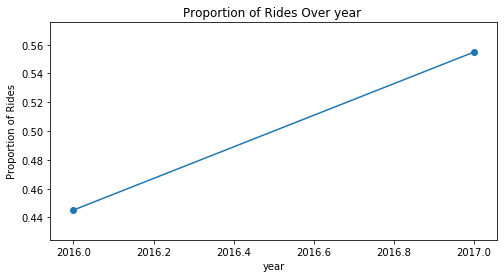

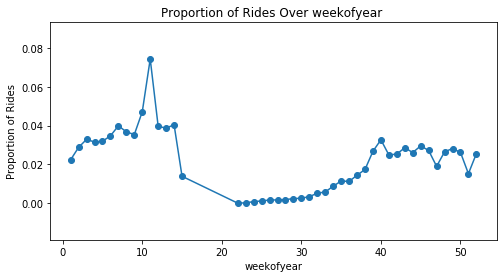

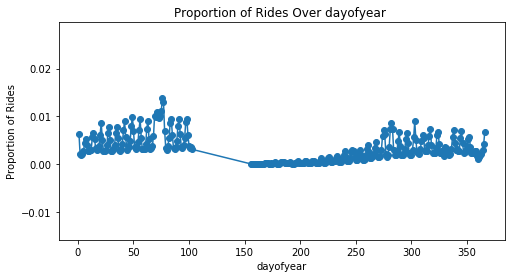

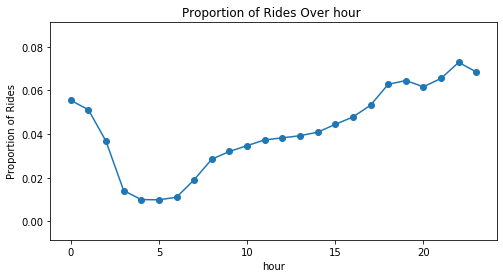

In [18]:
rel_col = ['weekday', 'month', 'day', 'year', 'weekofyear', 'dayofyear', 'hour']
for col in rel_col:
    explore_data(col, hourly_rides)

#### Rides on holidays

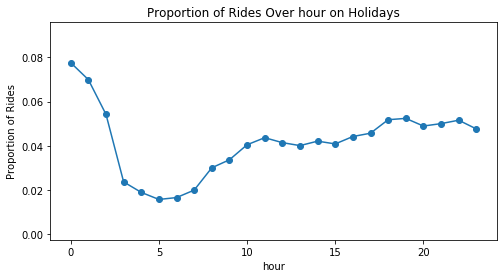

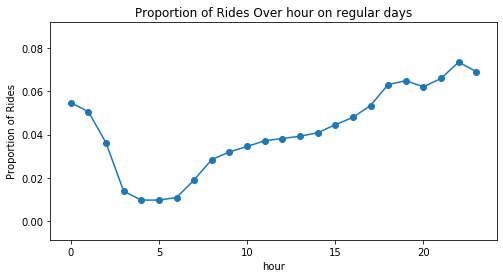

In [19]:
holidays = hourly_rides.loc[hourly_rides.us_holiday, :]
not_holidays = hourly_rides.loc[~(hourly_rides.us_holiday), :]

explore_data('hour', df=holidays, add_to_title='on Holidays')
explore_data('hour', df=not_holidays, add_to_title='on regular days')

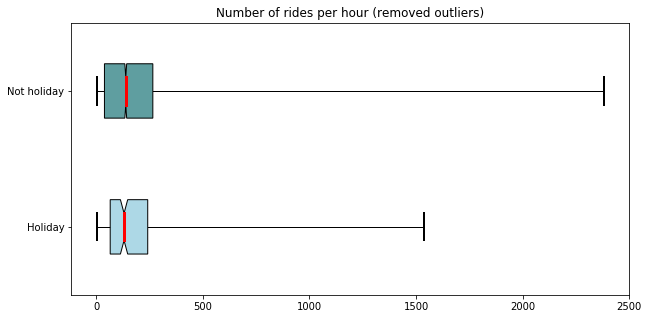

Average number of rides per hour in holidays: 170.0
Average number of rides per hour on other days: 206.0


In [20]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)

bp_data = [hourly_rides[hourly_rides.us_holiday].rides, hourly_rides[~hourly_rides.us_holiday].rides]
bp = ax.boxplot(bp_data, patch_artist = True,
                notch ='True', 
                vert = 0, whis='range', widths=(0.4,0.4))
 
colors = ['lightblue', 'cadetblue']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
    
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
    

ax.set_yticklabels(['Holiday', 'Not holiday'])

plt.title("Number of rides per hour (removed outliers)")

plt.show()

average_rides_per_hour_holiday = round(holidays.rides.sum() / holidays.shape[0])

average_rides_per_hour_not_holiday = round(not_holidays.rides.sum() / not_holidays.shape[0])

print('Average number of rides per hour in holidays: ' + str(average_rides_per_hour_holiday))
print('Average number of rides per hour on other days: ' + str(average_rides_per_hour_not_holiday))

#### Add lag feature to data

In [21]:
def add_weeks_lag(x, df, N):
    """Retrieves the number of rides taken at the same time of day N weeks prior"""
    
    # define the wanted delta:
    start_delta = datetime.timedelta(weeks=N)
    before_N_weeks = x - start_delta
    
    # define first week (no lag data)
    first_day_data = min(df_hourly_rides_merged['date'])
    date_list = [first_day_data + datetime.timedelta(days=x) for x in range(N*DAYS_A_WEEK)]

    # if current date is in the first N weeks in the database:
    if x in date_list:
        # Instead of removing this data, or filling it with 0's, I decided to fill it with this week's data
        # as from looking at the data at these time points it does not seem to be a far extrapolation
        ######################################################################################################
        ### NOTE: if the dataset is too small, this implementation may cause data leakage, as the test
        ### set might be fed with the wanted week rides in the lag feature
        ######################################################################################################
        return df.loc[x, 'rides']
    
    # if there were no documented rides N weeks ago: 
    elif before_N_weeks not in df.index:
        return 0

    else: # elif last_week in df['datetime'].values:
        return df.loc[before_N_weeks, 'rides']

#### Correlation analysis:

In [22]:
def plot_correlation(hourly_rides, N):
    """Plots the correlation between this each weeks' number of rides and number of rides N weeks ago."""
    corr_df = hourly_rides.loc[:,['rides','lag']]
    corr_df = corr_df[(~corr_df['rides'].isna()) & (~corr_df['lag'].isna())]

    pearsons_P = stats.stats.pearsonr(corr_df['rides'], corr_df['lag'])[1]
    pearsons_R = str(round(stats.stats.pearsonr(corr_df['rides'], corr_df['lag'])[0], 2))

    xy = np.vstack([corr_df.rides,corr_df.lag])
    z = stats.gaussian_kde(xy)(xy)
    plt.figure(figsize=(5, 4))
    sc = plt.scatter(corr_df.rides,corr_df.lag, c=z)
    plt.colorbar(sc)
    plt.xlabel('# Rides Current Week')
    plt.ylabel('# Rides' + str(N) + 'Week(s) ago')
    plt.title('Correlation and density between number of rides in week x and week x-' + str(N) + 
              '\n Pearson\'s Correlation: ' + pearsons_R + ' with P =' + str(pearsons_P))
    plt.show()
    return

In [23]:
def implement_lag(df, N):
    """Add lag feature to data and plots the correlation between this weeks' and lag weeks' number of rides"""
    df['lag'] = df['datetime'].apply(add_weeks_lag, df=df, N=N)
    plot_correlation(df, N)
    return df

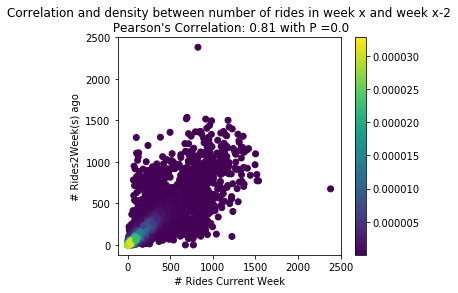

In [24]:
hourly_rides = implement_lag(hourly_rides, WEEKS_LAG_SIZE)

### Feature Engineering

In [25]:
hourly_rides.head()

,rides,date,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour,lag
created_on_hour,,,,,,,,,,,,,
2016-06-04 00:00:00,1,2016-06-04,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0,1
2016-06-04 01:00:00,1,2016-06-04,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1,1
2016-06-04 03:00:00,1,2016-06-04,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3,1
2016-06-04 09:00:00,1,2016-06-04,2016-06-04 09:00:00,5,6,4,2016,22,156,False,None,9,1
2016-06-04 10:00:00,1,2016-06-04,2016-06-04 10:00:00,5,6,4,2016,22,156,False,None,10,1


#### Categorical feature engineering (one-hot encoding)

1) Remove features that appears up to once in the whole dataset (e.g. specific holiday, certain week of year), so for current goal won't have added value.

2) Encode year

In [26]:
def categorical_engineering(df):
    """Handles categorial features with one-hot encoding or feature removal.""" 
    
    # Handle categorial (non cyclic) data- move to binary 0/1 features:
    df = pd.get_dummies(data=df, columns=['year'])

    # Remove 'us_holiday_type', 'dayofyear', 'month', 'weekofyear', 'date' for now
    df.drop(['us_holiday_type', 'dayofyear', 'month', 'weekofyear', 'date'], axis=1, inplace=True)
    return df

#### Train-test division

In [27]:
def train_test_division(df):
    """Divides into train and test sets."""
    
    train = df.loc[(df.datetime < '2017-03-30 00:00:00'), :]
    test = df.loc[(df.datetime >= '2017-03-30 00:00:00'), :]
    return train, test

#### Ordinal feature engineering

1) Ranked time of day

2) Ranked day of the week

In [28]:
def agg_ranked_feat(feat_name, train, df):
    """Adds a new ranked feature to the dataframe. Ranking is based on prevalence in the training set."""
    
    # aggreagate train rides per hour
    train_agg = train.groupby(feat_name)['rides'].sum().reset_index()
    
    new_feat = 'ranked_' + feat_name

    # define ranked crowded hours
    train_agg[new_feat] = train_agg.rides.rank(ascending=True)

    ordinal_dict = pd.Series(train_agg.loc[:, new_feat],
                         index=train_agg.loc[:, feat_name]).to_dict()

    # assign ranked hours on dataframe (based on train)
    df[new_feat] = df[feat_name].map(ordinal_dict)

    # remove hour in original df
    df.drop([feat_name], axis=1, inplace=True)

    return df

3) Ascending dates

In [29]:
def create_date_feature(df, ranking_method='dense'):
    """Creates a date feature by ranking the dates from early to late."""
    
    # get the dates
    df['date'] = df['datetime'].dt.date

    # rank dates
    df['ranked_date'] = df.date.rank(ascending=True, method=ranking_method)

    # remove hour in original df
    df.drop(['date'], axis=1, inplace=True)
    
    return df

4) Ranked day of month- based on the number of rides on each day of the month, normalized to the number of days that appear in the df (for example- 31st is less common, therefore I want to normalize to that).

In [30]:
def create_ordinal_day_of_month_feat(train, df):
    """Creates ordinal day of month feature. Calculates the normalized number of rides per day of month 1-31 and
    orders them based on crowdedness."""
    
    train_dayofmonth_agg = train.groupby('day')['rides'].sum().reset_index()

    num_days_df = train.day.value_counts().reset_index(name='num_days')

    train_dayofmonth_agg = pd.merge(train_dayofmonth_agg, num_days_df, left_on='day', right_on='index')

    train_dayofmonth_agg['rides_per_day'] = train_dayofmonth_agg.rides / train_dayofmonth_agg.num_days

    train_dayofmonth_agg['ranked_day_of_month'] = train_dayofmonth_agg.rides_per_day.rank(ascending=True)

    ordinal_day_of_month = pd.Series(train_dayofmonth_agg.ranked_day_of_month.values,
                             index=train_dayofmonth_agg.day).to_dict()


    df['ordinal_day_of_month'] = df['day'].map(ordinal_day_of_month)

    df.drop(['day'], axis=1, inplace=True)
    
    return df

### Baseline Model- Linear Regression

#### Divide train-test

In [31]:
# Define features and target
y = 'rides'
X_feat = ['us_holiday', 'lag', 'year_2016', 'year_2017', 'ranked_hour',
     'ranked_weekday', 'ranked_date', 'ordinal_day_of_month']

X_feat_binary = ['us_holiday', 'year_2016', 'year_2017']

X_feat_non_binary = list(set(X_feat) - set(X_feat_binary))

In [32]:
def create_train_test_xy(train, test):
    """Splits the data into features and target."""
    
    cur_X_feat = set(X_feat).intersection(set(train.columns))
    
    x_train = train[cur_X_feat]
    y_train = train[y]
    x_test = test[cur_X_feat]
    y_test = test[y]
    
    return x_train, y_train, x_test, y_test

#### Scaling

In [33]:
# custom scaler class:
class CustomScaler(): 
    """Class for custom scaler. Scales non-binary features in the data."""
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X):
        self.scaler.fit(X.loc[:, ~X.columns.isin(X_feat_binary)])
        return self

    def transform(self, X):
        X_head = self.scaler.transform(X.loc[:, ~X.columns.isin(X_feat_binary)])
        return np.concatenate((X_head, X.loc[:, X_feat_binary]), axis=1)

In [34]:
def use_scaler(x_train, x_test):
    """Runs the custom scaler."""
    # initiate & fit
    scaler = CustomScaler().fit(x_train)

    # transform train
    x_train = pd.DataFrame(scaler.transform(x_train))
    x_train.describe().transpose()

    # transform test
    x_test = pd.DataFrame(scaler.transform(x_test))

    # assign column names
    x_train.columns = X_feat_non_binary + X_feat_binary
    x_test.columns = X_feat_non_binary + X_feat_binary
    
    return x_train, x_test

#### Fit Model

In [35]:
# dataframe contains the current slicing of the dataframe (based on the sliding window) or the complete dataframe.
def adjust_features(df):
    """Adjusts features based on feature engineering defined above. Splits and scales the data."""

    # can be used over the whole dataframe
    df = categorical_engineering(df)

    # first time for feature engineering
    train, test = train_test_division(df)

    # run agg_ranked_feat function with 'hour', 'weekday'
    df = agg_ranked_feat('hour', train, df)
    
    df = agg_ranked_feat('weekday', train, df)

    df = create_date_feature(df, ranking_method='dense')
    
    df = create_ordinal_day_of_month_feat(train, df)

    # second time after feature engineering based on training set
    train, test = train_test_division(df)

    x_train, y_train, x_test, y_test,  = create_train_test_xy(train, test)

    # scaling
    x_train, x_test = use_scaler(x_train, x_test)
    
    return x_train, y_train, x_test, y_test

In [36]:
def run_linear_model(x_train, y_train, x_test):
    """Runs the linear model."""
    
    linear_model = LinearRegression().fit(x_train, y_train)
    y_pred = linear_model.predict(x_test)
    return y_pred

In [37]:
def plot_testdata_vs_prediction(test_pred, y_test, test):
    """Plots the actual test data rides and the respective predicted rides."""
    
    plt.figure(figsize=(12, 8))
    p1, = plt.plot(test.datetime, test.rides)
    p2, = plt.plot(test.datetime, test_pred)
    plt.title('The MAE for the test set of the baseline Linear Regression model is: ' + 
              str(round(mean_absolute_error(y_test, test_pred), 2)))
    plt.legend([p1, p2], ['Rides','Predicted Rides'])
    plt.xticks(rotation=45)
    plt.ylabel('Rides')
    plt.xlabel('Date')
    plt.show()
    
    return

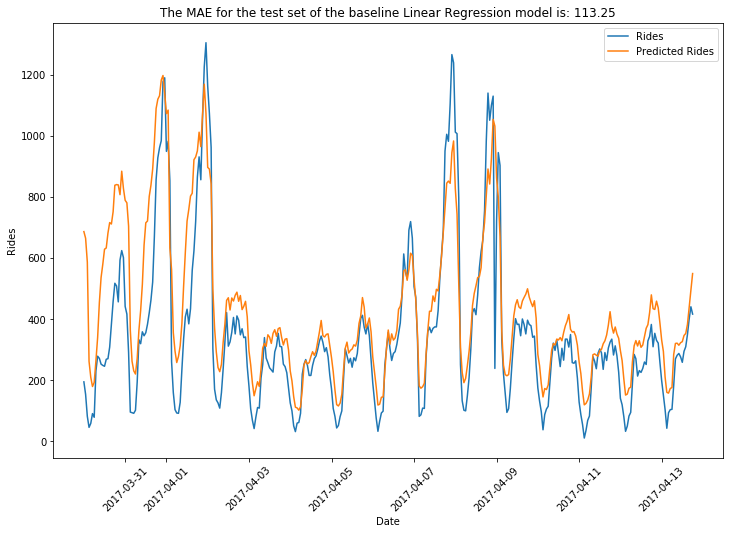

In [38]:
def predict_over_data(df):
    """Makes prediction over the input dataframe. Plots prediction and actual test data."""
    
    # for plot function:
    train, test = train_test_division(df)

    x_train, y_train, x_test, y_test = adjust_features(df)
    y_pred = run_linear_model(x_train, y_train, x_test)
    plot_testdata_vs_prediction(y_pred, y_test, test)

predict_over_data(hourly_rides)

#### Model error evaluation:

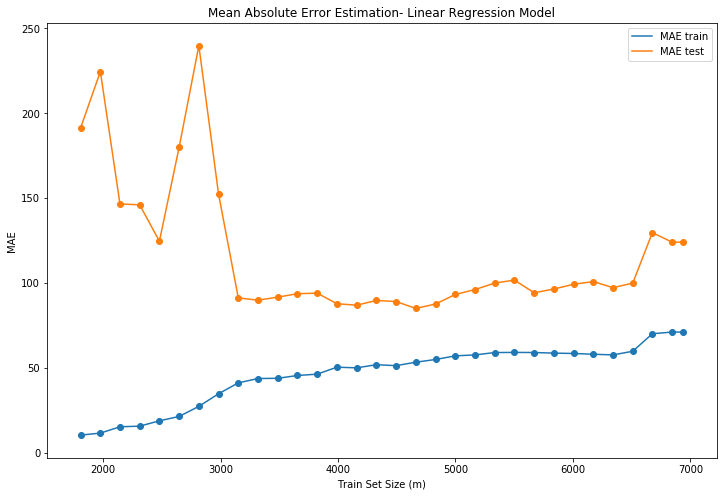

In [39]:
def plot_mae(MAE_test, MAE_train, m):
    """Plots the mean absolute error over training set size for a linear regression model."""
    
    plt.figure(figsize=(12, 8))
    p1, = plt.plot(m, MAE_train)
    p2, = plt.plot(m, MAE_test)
    p3 = plt.scatter(m, MAE_train)
    p4 = plt.scatter(m, MAE_test)
    plt.title('Mean Absolute Error Estimation- Linear Regression Model')
    plt.legend([p1, p2], ['MAE train','MAE test'])
    plt.xlabel('Train Set Size (m)')
    plt.ylabel('MAE')
    plt.show()
    
    return


def calculate_mae_linear_model(x_train, y_train, x_test, y_test):
    """Calculates and returns the mean absolute error for the train and test set using a linear regression model."""
    
    y_pred = run_linear_model(x_train, y_train, x_test)

    MAE_test = mean_absolute_error(y_test, y_pred)

    y_pred_train = run_linear_model(x_train, y_train, x_train)
    MAE_train = mean_absolute_error(y_train, y_pred_train)
    
    return MAE_test, MAE_train
    

def sliding_training_set_mae(train, test, weeks_sliding_window):
    """Creates a sliding window training set and calculates its MAE.
    Returns an MAE list for the train and test sets and a list of training set sizes."""
    
    MAE_test_list = []
    MAE_train_list = []
    train_size_list = []
      
    first_day_data = min(train['date'])
    
    iteration = 0
    weeks_after = first_day_data + \
    datetime.timedelta(weeks=BASIC_TRAINING_SET_NUM_WEEKS+(weeks_sliding_window*iteration))
    
    # create train with sliding window
    while weeks_after <= max(train['date']):
        
        cur_train = train.loc[(train.date >= first_day_data) & (train.date <= weeks_after)]
        train_size_list.append(cur_train.shape[0])
        
        # adjust features (engineer + scale) based on current training set:
        cur_df = pd.concat([cur_train, test])
        x_train, y_train, x_test, y_test = adjust_features(cur_df)
        
        MAE_test, MAE_train = calculate_mae_linear_model(x_train, y_train, x_test, y_test)
        
        MAE_train_list.append(MAE_train)
        MAE_test_list.append(MAE_test)
        
        iteration += 1
        weeks_after = first_day_data + \
        datetime.timedelta(weeks=BASIC_TRAINING_SET_NUM_WEEKS+(weeks_sliding_window*iteration))
        
    # calculate MAE over the whole training set
    MAE_test, MAE_train = calculate_mae_linear_model(x_train, y_train, x_test, y_test)
    MAE_train_list.append(MAE_train)
    MAE_test_list.append(MAE_test)
    train_size_list.append(train.shape[0])
    
    
    return MAE_test_list, MAE_train_list, train_size_list


def mae_analysis(df, weeks_sliding_window=SLIDING_WINDOW_WEEK_STEP_SIZE):
    """Analyzes the MAE of the linear model"""
    train, test = train_test_division(df)
    MAE_test_list, MAE_train_list, train_size_list = sliding_training_set_mae(train, test, weeks_sliding_window)
    plot_mae(MAE_test_list, MAE_train_list, train_size_list)
    

mae_analysis(hourly_rides)